In [2]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
from paper_sims_util import MCC
from running_wrappers import get_loaders
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
LOADERS = get_loaders()
AlgoParams = namedtuple('AlgoParams', 'stability_samples M pi')
GraphParams = namedtuple('GraphParams', 'N eta p d ratios')
import pandas as pd
import time

In [ ]:
#S-H calculation

# total trials: 50
# for each graph, run MTP2 N_SAMPLE times at 10 seconds each
# graphs, parameters
#for each graph, run MTP2 N_SAMPLES times, (10 seconds)
10 seconds * N_samples * # graphs 
#graphs = 4 * 4 = 16 * trials per graph

In [20]:
run_name = 'DO_p_100_slashedp'
run_ids = range(20)
with open("{}_algo_params.pkl".format(run_name), 'rb') as f:
    algo_params = pickle.load(f)
with open("{}_graph_params_dict.pkl".format(run_name), 'rb') as f:
    graph_params_dict = pickle.load(f)
# graph_params_dict = {
#     'chain': GraphParams(p=20, N=[20, 25, 30, 35, 40], eta=1, ratios=None, d=None), #p, N, eta
#     'star': GraphParams(p=20, d=[10, 15, 20, 25, 30], N=50, eta=1, ratios=None), #p, d, N, eta
#     'random': GraphParams(p=20, d=0.01, ratios=[r/500. for r in [300, 375, 500, 750, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
#     'grid_3D': GraphParams(p=2, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None), #p, ratio over 524, eta
#     'grid': GraphParams(p=7, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None) #p, ratio over 529, eta
# }

In [21]:
graph_params_dict = {'chain': GraphParams(N=[25, 50, 100, 200, 500, 1000], eta=1, p=100, d=None, ratios=None), 
                     'star': GraphParams(N=50, eta=1, p=100, d=[2,3, 4, 5], ratios=None), 
                     'random': GraphParams(N=None, eta=1, p=100, d=0.01, ratios=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0]), 
                     'grid': GraphParams(N=None, eta=1, p=10, d=None, ratios=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0])}

In [6]:
def get_new_omega_hat(MTP2_precs):
    from final_algo import attr_threshold_new, get_stability_edges
    p = 100
    pi = 0.7
    lambdas = [0., 0.01, 0.05, 0.1, 0.2, 0.3]
    results = defaultdict(list)
    probs = {}
    edges = []
    for i in range(p):
        for j in range(i+1, p):
            edges.append((i,j))
    for q in lambdas:
        for prec in MTP2_precs:
            results[q].append(attr_threshold_new(prec, q))

        probs[q] = defaultdict(int)
        for res in results[q]:
            for e in edges:
                e_val = res[e]
                if e_val != 0:
                    probs[q][e] += 1
        for e in edges:
            probs[q][e] /= len(results[q])

    stable_edges = get_stability_edges(probs, lambdas, pi)
    omega = np.zeros((p,p))
    for e in stable_edges:
        omega[e] = 1
        omega[e[::-1]] = 1
    return omega

In [5]:
def get_points(loaded_data):
    points = defaultdict(lambda: defaultdict(list))
    print(loaded_data.keys())
    for x_label, trials in loaded_data.items(): #x_;
        print(x_label)
        for t_i, trial in enumerate(trials):
            if t_i > 5: #use 5 trials only
                continue
            print(t_i)
            #print(type(trial))
#             if type(trial) != dict:
#                 continue
            #print(x_label)
            #print(trials.keys())
            omega = trial[0]
            #print(np.sum(omega))
            results = trial[1]
            for algo_name, algo_results in results.items():
                if algo_name == 'SH':
                    omega_hat = get_new_omega_hat(algo_results[3])
                else:
                    omega_hat = algo_results[0]
                #print(algo_name, np.sum(omega_hat))
                algo_mcc = MCC(omega_hat, omega)
                points[algo_name][x_label].append(algo_mcc)
        print(points)
    return points

In [ ]:
graph_params_dict = {
    'chain': GraphParams(p=100, N=[25, 50, 100, 200, 500, 1000], eta=1, ratios=None, d=None), #p, N, eta
    'star': GraphParams(p=100, d=[10, 20, 30, 50], N=50, eta=1, ratios=None), #p, d, N, eta
    'random': GraphParams(p=100, d=0.01, ratios=[r/100. for r in [25, 50, 100, 200, 500, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
    #'grid_3D': GraphParams(p=4, ratios=new_grid_ratios, eta=2, N=None, d=None), #p, ratio over 524, eta
    'grid': GraphParams(p=10, ratios=[r/100. for r in [500,1000]], eta=1, N=None, d=None) #p, ratio over 529, eta
}
run_name = 'NIPS_rebuttal_clime'
run_ids = [0,1]
algo_params = AlgoParams(stability_samples=50, M=7./9., pi=0.8)
LOADED_DATA = LOADERS['random'](graph_params_dict['random'], 
                                  algo_params, 
                                  run_name,
                                  run_ids)

In [44]:
new_points = get_points(LOADED_DATA)

dict_keys([25, 50, 100, 200, 500, 1000])
25
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fbf8>, {'our': defaultdict(<class 'list'>, {25: [0.23238616400293136]}), 'tiger': defaultdict(<class 'list'>, {25: [0]})})
50
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fbf8>, {'our': defaultdict(<class 'list'>, {25: [0.23238616400293136], 50: [0.36330652284980947]}), 'tiger': defaultdict(<class 'list'>, {25: [0], 50: [0]})})
100
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fbf8>, {'our': defaultdict(<class 'list'>, {25: [0.23238616400293136], 50: [0.36330652284980947], 100: [0.7971051377573558]}), 'tiger': defaultdict(<class 'list'>, {25: [0], 50: [0], 100: [0.38153247446045285]})})
200
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fbf8>, {'our': defaultdict(<class 'list'>, {25: [0.23238616400293136], 50: [0.36330652284980947], 100: [0.7971051377573558], 200: [0.9896423604508253]}), 'tiger': defaultdict(<class 'list'>, {25: [

In [45]:
run_name = 'NIPS_rebuttal_ALL'
points, lines = plot('random', ret=True)

Loaded data
dict_keys([25, 50, 100, 200, 500, 1000])
25
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fae8>, {'our': defaultdict(<class 'list'>, {25: [0.3247111758487925]}), 'tiger': defaultdict(<class 'list'>, {25: [0]}), 'clime': defaultdict(<class 'list'>, {25: [0]})})
50
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fae8>, {'our': defaultdict(<class 'list'>, {25: [0.3247111758487925], 50: [0.4629623016275518]}), 'tiger': defaultdict(<class 'list'>, {25: [0], 50: [0]}), 'clime': defaultdict(<class 'list'>, {25: [0], 50: [0]})})
100
0
defaultdict(<function get_points.<locals>.<lambda> at 0x12470fae8>, {'our': defaultdict(<class 'list'>, {25: [0.3247111758487925], 50: [0.4629623016275518], 100: [0.9204418823932796]}), 'tiger': defaultdict(<class 'list'>, {25: [0], 50: [0], 100: [0.5834148688386414]}), 'clime': defaultdict(<class 'list'>, {25: [0], 50: [0], 100: [0.4663357823889656]})})
200
0
defaultdict(<function get_points.<locals>.<lambda> at 0x1247

In [46]:
lines

([25, 50, 100, 200, 500, 1000],
 defaultdict(list,
             {'our': [0.3247111758487925,
               0.4629623016275518,
               0.9204418823932796,
               0.9902368569825387,
               1.0,
               1.0],
              'tiger': [0.0,
               0.0,
               0.5834148688386414,
               0.677103317506553,
               0.8581460875205482,
               0.6505993347537503],
              'clime': [0.0,
               0.0,
               0.4663357823889656,
               0.909359037791828,
               0.9902368569825387,
               0.9820987917031032]}))

In [14]:
def plot_lines(d):
    lines = defaultdict(list)
    x_labels = list(next(iter(d.values())).keys())
    for algo_name, x_label_to_trials in d.items():
        for x_label in x_labels:
            trial_MCCs = x_label_to_trials[x_label]
            lines[algo_name].append(np.mean(trial_MCCs))
    return x_labels, lines

In [9]:
def plot(graph_type, ret = False):
    loaded_data = LOADERS[graph_type](graph_params_dict[graph_type], 
                                  algo_params, 
                                  run_name,
                                  run_ids)
    print('Loaded data')
    points = get_points(loaded_data)
    lines = plot_lines(points)
    if ret:
        return points, lines
    for algo, line in lines[1].items():
        plt.plot(lines[0], line, label=algo)
    plt.title(graph_type)
    plt.legend()
    plt.show()

In [87]:
graph_type = 'random'
try:
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'rb') as f:
        points,lines = pickle.load(f)
#     with open('{}_{}_lines_extra.pkl'.format(run_name, graph_type), 'rb') as f:
#         extra = pickle.load(f)
except:
    points, lines = plot(graph_type, True)
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'wb') as f:
        pickle.dump((dict(points),lines), f)

#### To add additional metrics

In [77]:
from final_algo import SH_lambda_wrapper, new_algo
from paper_sims_util import grid_graph, random_graph, chain, confusion
graph = random_graph(100, 0.01)
sh_lambdas = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
sh_other_lambdas = [0., 0.01, 0.05, 0.1, 0.2, 0.3]
WHICH_LAMBDAS = sh_lambdas + sh_other_lambdas 
lambdas_to_res = defaultdict(list)
start = time.time()
for N in [25,50,100,200, 500, 1000]:
    print(N)
    X = np.random.multivariate_normal(np.zeros(100), np.linalg.inv(graph), N)
    sh_res, _ = SH_lambda_wrapper(X, WHICH_LAMBDAS)
    for lamb, omega_hat in sh_res.items():
#         TP, TN, FP, FN = confusion(omega_hat, graph)
#         TPR = TP/(TP + FN)
#         FPR = FP/(FP + TN)
        mcc = MCC(omega_hat, graph)
        #print(lamb, ":", TPR, FPR, mcc)
        lambdas_to_res[lamb].append(mcc)
#print(lambdas_to_res)
print(time.time() - start)

25
50
100
200
500
1000
105.04951596260071


In [78]:
SH_best_lambdas = []
SH_best_res = []
for i in range(6):
    N_res = []
    for l in lambdas_to_res.keys():
        N_res.append(lambdas_to_res[l][i])
    best = max(N_res)
    best_l = list(lambdas_to_res.keys())[np.argmax(N_res)]
    SH_best_lambdas.append(best_l)
    SH_best_res.append(best)

In [79]:
print(SH_best_res)
print(SH_best_lambdas)

[0.271152222804026, 0.3573292196115288, 0.5333698062021649, 0.5905547355036888, 0.6262545417259255, 0.6435545226818463]
[0.01, 0.05, 0.05, 0.05, 0.05, 0.05]


In [249]:
from final_algo import new_algo
graph = grid_graph(10)
res = [0.193828297809358, 0.37307241242620476, 0.6849048978277202, 0.894310804995154]
for N in [500, 1000]:
    X = np.random.multivariate_normal(np.zeros(100), np.linalg.inv(graph), N)
    omega_hat = new_algo(X, 0.85)
    TP, TN, FP, FN = confusion(omega_hat, graph)
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    mcc = MCC(omega_hat, graph)
    print(TPR, FPR, mcc)
    res.append(mcc)

Running new algorithm
N=500, M=196
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
1.0 0.0 1.0
Running new algorithm
N=1000, M=354
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
1.0 0.0 1.0


In [250]:
res

[0.193828297809358,
 0.37307241242620476,
 0.6849048978277202,
 0.894310804995154,
 1.0,
 1.0]

In [88]:
lines[1]['SH_best'] = SH_best_res
#lines[1]['our_85'] = res

In [98]:
lines = pickle.load(open('grid_ALL_lines.pkl', 'rb'))

In [287]:
with open('grid_ALL_lines.pkl', 'wb') as f:
    pickle.dump(lines, f)

### Generate Plot

In [94]:
graph_type = 'grid'
try:
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'rb') as f:
        points,lines = pickle.load(f)
#     with open('{}_{}_lines_extra.pkl'.format(run_name, graph_type), 'rb') as f:
#         extra = pickle.load(f)
except:
    points, lines = plot(graph_type, True)
    with open('{}_{}_points_lines.pkl'.format(run_name, graph_type), 'wb') as f:
        pickle.dump((dict(points),lines), f)

In [63]:
#To use new value of SH lol
lines = new_lines

In [68]:
new_lines

([25, 50],
 defaultdict(list,
             {'our': [0.27464882127676016, 0.48177578123423237],
              'SH': [0.07212161716943423, 0.07461103309779746],
              'glasso': [0.0, 0.42590747456001676],
              'nbsel': [0.3081346461710842, 0.412110951733384],
              'anand': [0.19646773173426724, 0.22788439060784066]}))

In [40]:
tups = []
for algo_name in lines[1].keys():
    for t in zip(lines[0], lines[1][algo_name]):
        tups.append((algo_name,) + t)

In [41]:
df = pd.DataFrame(tups, columns = ['Algorithm', 'N', 'MCC'])

In [42]:
df

,Algorithm,N,MCC
0,our,25,0.607664
1,our,50,0.936472
2,our,100,1.000000
3,our,200,1.000000
4,our,500,1.000000
5,our,1000,1.000000
6,tiger,25,0.000000
7,tiger,50,0.000000
8,tiger,100,0.592444
9,tiger,200,0.464350


Manually set graph type


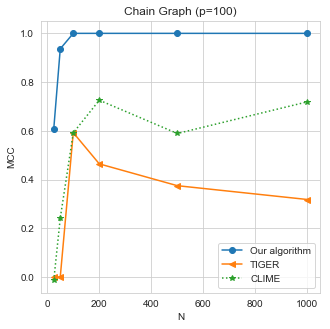

KeyboardInterrupt: 

In [43]:
groupby = df.groupby('Algorithm')
labels = {'our': 'Our algorithm', 
          'SH_best': 'SH (best q)', 
          'SH_0.7': 'SH (no stability selection)',
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$',
          'tiger': 'TIGER',
          'clime': 'CLIME'}
markers = {'our': 'o', 
           'SH_best': '<', 
           'SH_0.7': '<', 
           'SH': '>', 
           'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*', 
          'tiger': '<', 'clime': '*'}
linestyles = {'our': 'solid', 
              'SH_best': 'dashdot', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid', 'tiger': 'solid', 'clime': 'dotted'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_best': 'C6',
    'SH_0.7': 'C6',
    'our_85': 'C9',
    'tiger': 'C1',
    'clime': 'C2'
}
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))
#plt.xlim((0,1000))
all_graphs = ['our', 'our_85', 'SH', 'SH_0.7', 'nbsel', 'glasso', 'anand']
main_graphs = ['our', 'SH', 'nbsel', 'glasso', 'anand', 'SH_best']
relevant_graphs = ['our', 'our_85', 'SH', 'SH_0.7']
rebuttal_graphs = ['our', 'tiger', 'clime']
use_graphs = rebuttal_graphs
for algo_name in use_graphs:
    item = groupby.get_group(algo_name)
    plt.plot(item.N, item.MCC, 
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name])

plt.legend(loc='lower right')
graph_type = 'Chain Graph (p=100)'
print("Manually set graph type")
plt.title(graph_type)
plt.xlabel("N")
plt.ylabel("MCC")
plt.show()
save_path = 'rebuttal_images/{}_no_stab.png'
if input("save to {}".format(save_path)) == 'Y':
    fig.savefig('final_images/{}_no_stab.png'.format(graph_type))